<a href="https://colab.research.google.com/github/cyrilgabriele/RL/blob/main/Lab13/DQN_lands_on_the_moon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graded lab: Implement DQN for LunarLander

This notebook originates from the Deep RL Course on HuggingFace and has been modified.
You're not expected to understand the topic of PPO yet, so you can safely ignore that part.

![Cover](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/thumbnail.jpg)

In this notebook, you'll train your **DQN agent** - a Lunar Lander agent that will learn to **land correctly on the Moon 🌕**. Using [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/) a Deep Reinforcement Learning library, share them with the community, and experiment with different configurations

⬇️ Here is an example of what **you will achieve in just a couple of minutes.** ⬇️




In [10]:
%%html
<video controls autoplay><source src="https://huggingface.co/sb3/ppo-LunarLander-v2/resolve/main/replay.mp4" type="video/mp4"></video>

### The environment 🎮

- [LunarLander-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

### The library used 📚

- [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/)

We're constantly trying to improve our tutorials, so **if you find some issues in this notebook**, please [open an issue on the Github Repo](https://github.com/huggingface/deep-rl-class/issues).

## Install dependencies and create a virtual screen 🔽

The first step is to install the dependencies, we’ll install multiple ones.

- `gymnasium[box2d]`: Contains the LunarLander-v2 environment 🌛
- `stable-baselines3[extra]`: The deep reinforcement learning library.
- `huggingface_sb3`: Additional code for Stable-baselines3 to load and upload models from the Hugging Face 🤗 Hub.

To make things easier, we created a script to install all these dependencies.

In [11]:
!apt install swig cmake

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [12]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames).

Hence the following cell will install virtual screen libraries and create and run a virtual screen 🖥

In [13]:
!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 110 kB in 1s (114 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
0 upgraded, 0 newly installed, 0 to 

To make sure the new installed libraries are used, **sometimes it's required to restart the notebook runtime**. The next cell will force the **runtime to crash, so you'll need to connect again and run the code starting from here**. Thanks to this trick, **we will be able to run our virtual screen.**

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## Import the packages 📦

One additional library we import is huggingface_hub **to be able to upload and download trained models from the hub**.


The Hugging Face Hub 🤗 works as a central place where anyone can share and explore models and datasets. It has versioning, metrics, visualizations and other features that will allow you to easily collaborate with others.

You can see here all the Deep reinforcement Learning models available here👉 https://huggingface.co/models?pipeline_tag=reinforcement-learning&sort=downloads



In [2]:
import gymnasium as gym

from huggingface_sb3 import load_from_hub, package_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor


import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

%matplotlib inline

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create the LunarLander environment 🌛 and understand how it works

### [The environment 🎮](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

In this first tutorial, we’re going to train our agent, a [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/), **to land correctly on the moon**. To do that, the agent needs to learn **to adapt its speed and position (horizontal, vertical, and angular) to land correctly.**

---


💡 A good habit when you start to use an environment is to check its documentation

👉 https://gymnasium.farama.org/environments/box2d/lunar_lander/

---


In [3]:
# We create our environment with gym.make("<name_of_the_environment>")
env = gym.make("LunarLander-v2")
state = env.reset()
print(state)

print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape", env.observation_space.shape)
print("Sample observation", env.observation_space.sample()) # Get a random observation

(array([ 0.00708733,  1.4067409 ,  0.71785206, -0.1857565 , -0.00820563,
       -0.16260421,  0.        ,  0.        ], dtype=float32), {})
_____OBSERVATION SPACE_____ 

Observation Space Shape (8,)
Sample observation [80.09238    -8.077896   -4.653369    3.3747466   0.1592296   2.291557
  0.87674665  0.54341877]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_res

We see with `Observation Space Shape (8,)` that the observation is a vector of size 8, where each value contains different information about the lander:
- Horizontal pad coordinate (x)
- Vertical pad coordinate (y)
- Horizontal speed (x)
- Vertical speed (y)
- Angle
- Angular speed
- If the left leg contact point has touched the land (boolean)
- If the right leg contact point has touched the land (boolean)


In [4]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 0


The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:

- Action 0: Do nothing,
- Action 1: Fire left orientation engine,
- Action 2: Fire the main engine,
- Action 3: Fire right orientation engine.

Reward function (the function that will gives a reward at each timestep) 💰:

After every step a reward is granted. The total reward of an episode is the **sum of the rewards for all the steps within that episode**.

For each step, the reward:

- Is increased/decreased the closer/further the lander is to the landing pad.
-  Is increased/decreased the slower/faster the lander is moving.
- Is decreased the more the lander is tilted (angle not horizontal).
- Is increased by 10 points for each leg that is in contact with the ground.
- Is decreased by 0.03 points each frame a side engine is firing.
- Is decreased by 0.3 points each frame the main engine is firing.

The episode receive an **additional reward of -100 or +100 points for crashing or landing safely respectively.**

An episode is **considered a solution if it scores at least 200 points.**

#### Vectorized Environment

- We create a vectorized environment (a method for stacking multiple independent environments into a single environment) of 16 environments, this way, **we'll have more diverse experiences during the training.**

In [5]:
# Create the environment
envs = make_vec_env('LunarLander-v2', n_envs=16)
print(envs.action_space.sample()) #test random action on envs

2


## Create the Model 🤖

We have studied our environment and we understood the problem: **being able to land the Lunar Lander to the Landing Pad correctly by controlling left, right and main orientation engine**. Now let's build the algorithm we're going to use to solve this Problem 🚀.

To solve this problem, you're going to implement DQN from scratch.

In [6]:
import torch.nn.init as init

In [7]:
# TODO: Define your DQN agent from scratch!
class DQN_Lunar_Lander(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_Lunar_Lander, self).__init__()

        self.layerList = nn.ModuleList()
        # n_observations = 8 here with LunarLander-V2 env
        self.input_size = n_observations
        self.hidden_layer_size = 128
        self.num_hidden_layers = 3
        # n_actions = 4 here with LunarLander-V2 env
        self.output_size = n_actions

        # Input Layer
        self.layerList.append(nn.Linear(self.input_size, self.hidden_layer_size))
        self.layerList.append(nn.ReLU())

        # Hidden Layers
        for _ in range(self.num_hidden_layers):
          linear_layer = nn.Linear(self.hidden_layer_size, self.hidden_layer_size)
          init.kaiming_uniform_(linear_layer.weight, mode='fan_in', nonlinearity='relu')
          self.layerList.append(linear_layer)
          self.layerList.append(nn.ReLU())

        # Output Layer
        linear_output_layer = nn.Linear(self.hidden_layer_size, self.output_size)
        init.kaiming_uniform_(linear_output_layer.weight, mode='fan_in', nonlinearity='linear')
        self.layerList.append(linear_output_layer)
        # END TODO

    def forward(self, state):
      for i, layer in enumerate(self.layerList):
        state = layer(state)
        # print(f"Output after layer {i + 1}: {x.shape}")
        # print(f"x in forward: {x}")
      return state



Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.005
LR = 7e-4

n_actions = envs.action_space.n
# Get the number of state observations
state = envs.reset()
n_observations = len(state[0])



policy_net = DQN_Lunar_Lander(n_observations, n_actions).to(device)
target_net = DQN_Lunar_Lander(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)


steps_done = 0


def select_actions(states):
    global steps_done
    sample = random.random()
    actions = []
    for state in states:
      eps_threshold = get_epsilon(steps_done)
      if sample > eps_threshold:
          with torch.no_grad():
              actions.append(policy_net.forward(state).max(1)[1].item())
      else:
          actions.append(envs.action_space.sample())
      steps_done += 1
    return actions


episode_durations = [[] for _ in range(envs.num_envs)]

def get_epsilon(step_number):
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * step_number / EPS_DECAY)

## Train the DQN agent 🏃
- Let's train our agent for 1,000,000 timesteps, don't forget to use GPU on Colab. It will take approximately ~20min, but you can use fewer timesteps if you just want to try it out.
- During the training, take a ☕ break you deserved it 🤗

#### Solution

In [8]:
# TODO: Train it for 1,000,000 timesteps

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected state-action values (Q values)
    # TODO: write the function to compute the expected Q values
    #   Q(s,a) = Q(s,a)*GAMMA +  r
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


# Initialize the environment and get it's state. environments resets automatically when reaching a terminal state
states = envs.reset() # 2d array containing the 16 observations of the 16 environments
# print(states.shape)
# print(states)
states = [torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) for state in states]
# print(states.shape)
# print(states)

rewards_accumulator = np.zeros(envs.num_envs)

while steps_done < 1000000:
    actions = select_actions(states)
    # print("action", actions)
    observations, rewards, dones, _ = envs.step(actions)
    observations = [torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0) for observation in observations]
    # print("rewards", rewards)
    rewards = [torch.tensor([reward], device=device) for reward in rewards]
    actions = [torch.tensor([[action]], device=device) for action in actions]
    # print("element of actions", actions[0])
    for env_index in range(envs.num_envs):
        rewards_accumulator[env_index] += rewards[env_index].item()
        if dones[env_index]:
            next_state = None
            episode_durations[env_index].append(rewards_accumulator[env_index])
            # plot_durations()
            rewards_accumulator[env_index] = 0
        else:
            next_state = observations[env_index]

        # Store the transition in memory
        memory.push(states[env_index], actions[env_index], next_state, rewards[env_index])

    # Move to the next state
    states = observations

    # Perform one step of the optimization (on the policy network)
    optimize_model()

    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

print('Complete')

Complete


# Plot training

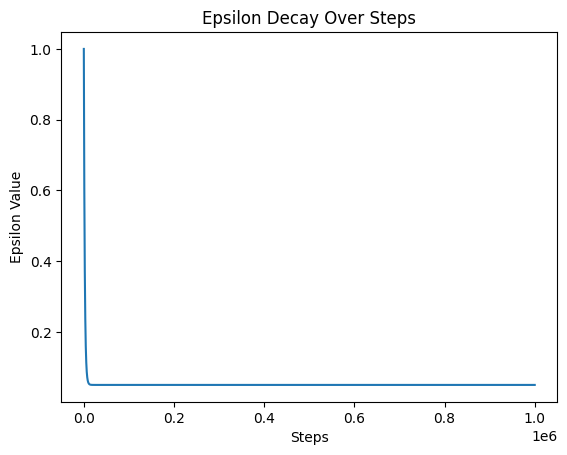

Environment 1 has 97 episodes that scored more than 200 points.
Environment 2 has 96 episodes that scored more than 200 points.
Environment 3 has 91 episodes that scored more than 200 points.
Environment 4 has 89 episodes that scored more than 200 points.
Environment 5 has 96 episodes that scored more than 200 points.
Environment 6 has 101 episodes that scored more than 200 points.
Environment 7 has 89 episodes that scored more than 200 points.
Environment 8 has 102 episodes that scored more than 200 points.
Environment 9 has 98 episodes that scored more than 200 points.
Environment 10 has 91 episodes that scored more than 200 points.
Environment 11 has 87 episodes that scored more than 200 points.
Environment 12 has 96 episodes that scored more than 200 points.
Environment 13 has 99 episodes that scored more than 200 points.
Environment 14 has 93 episodes that scored more than 200 points.
Environment 15 has 94 episodes that scored more than 200 points.
Environment 16 has 100 episodes 

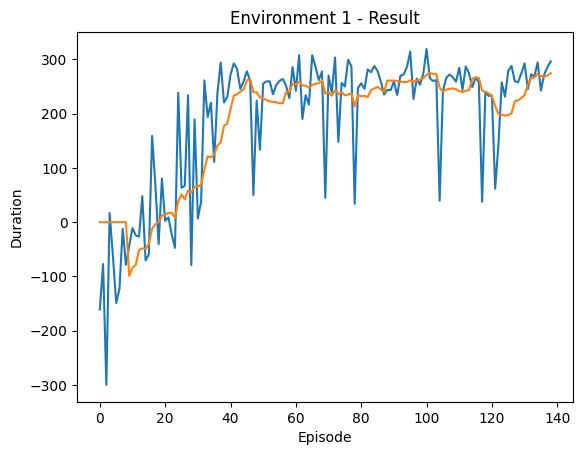

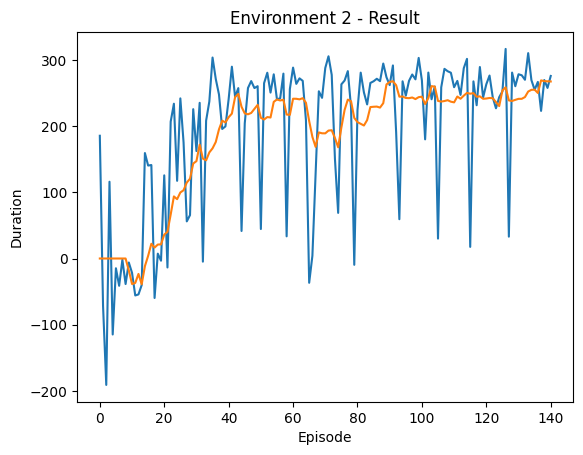

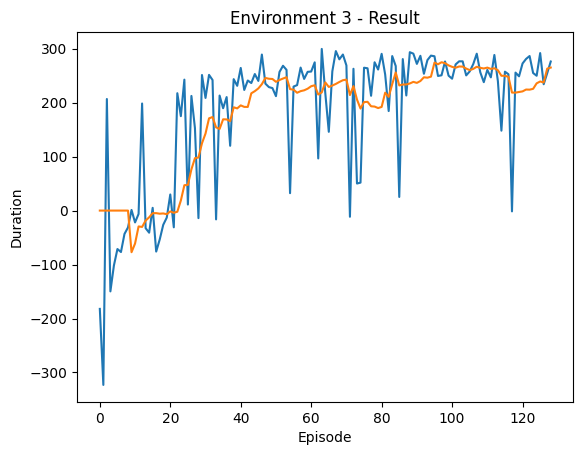

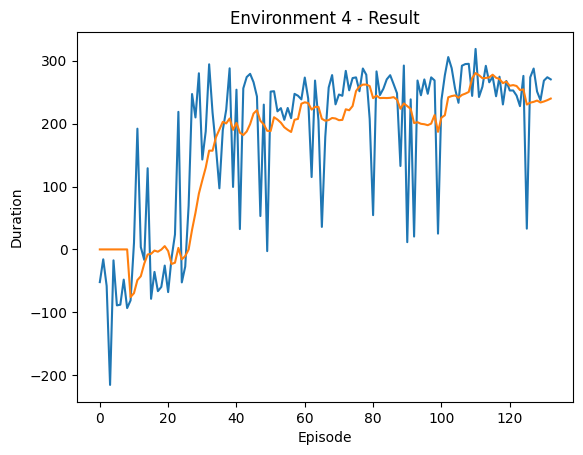

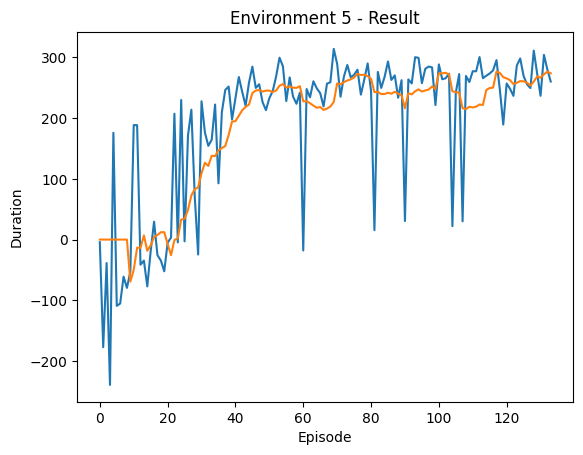

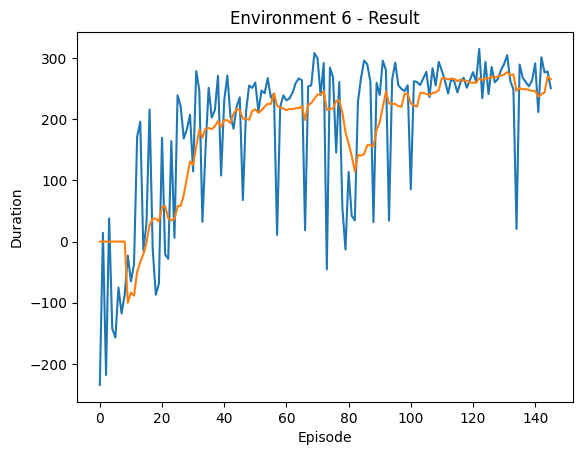

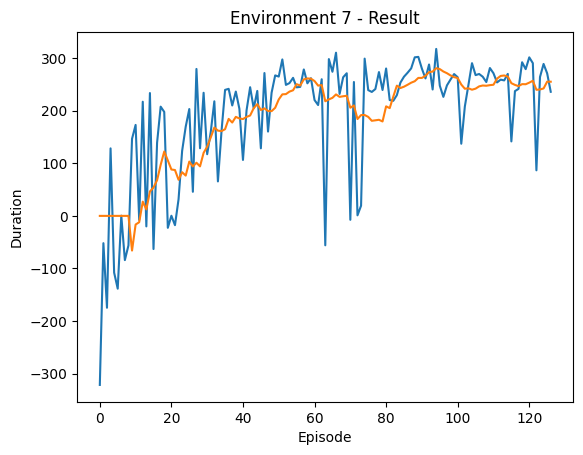

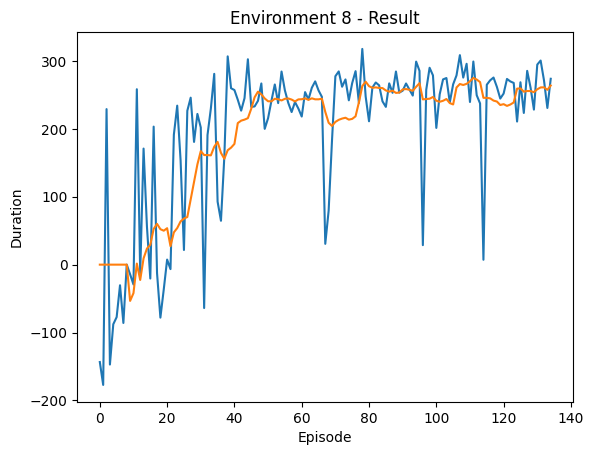

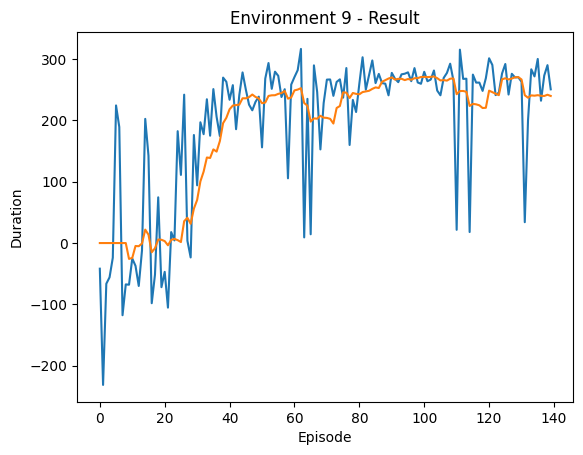

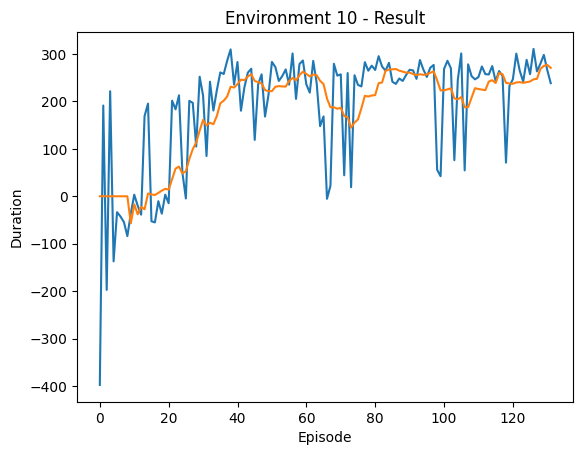

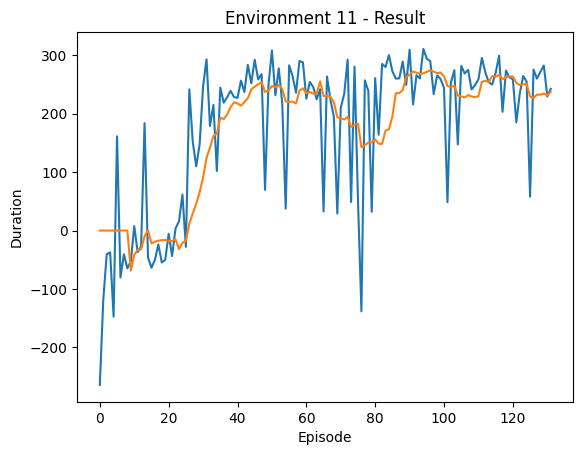

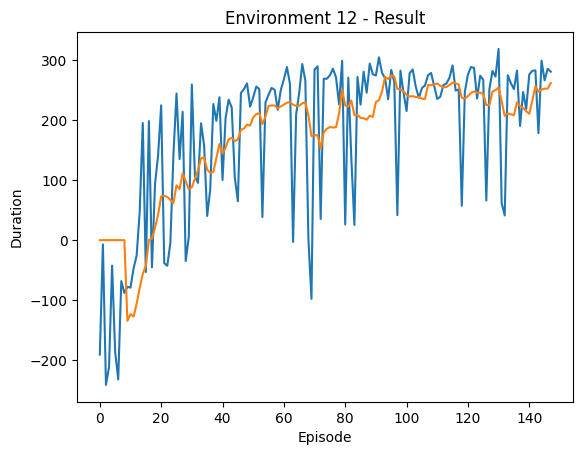

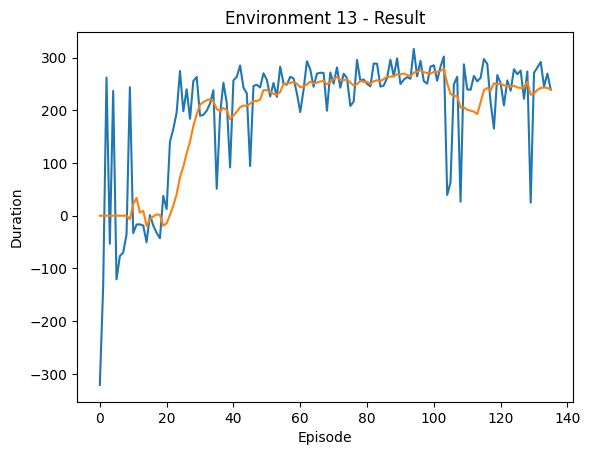

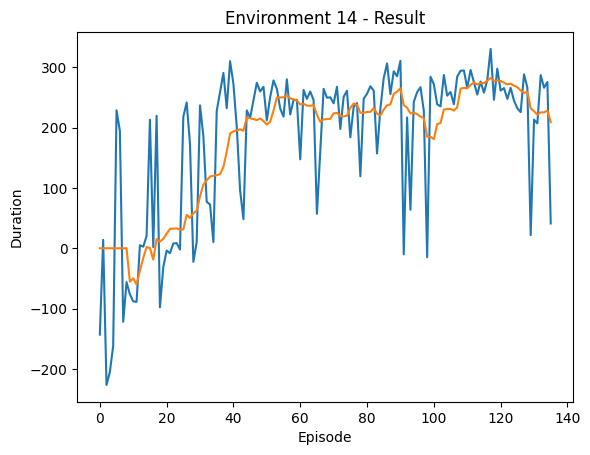

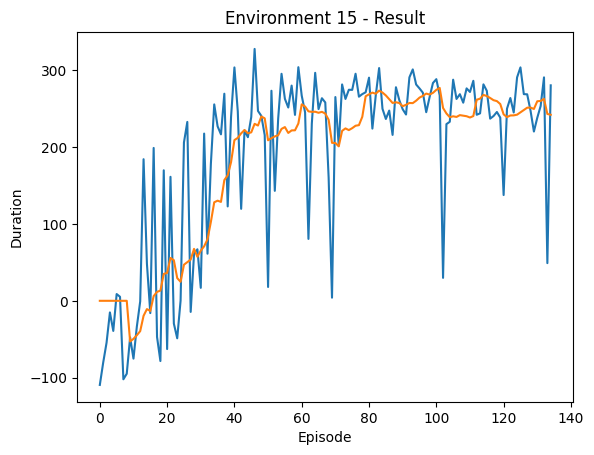

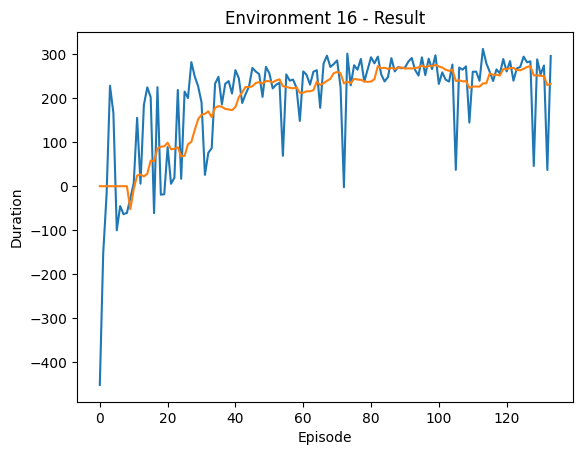

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
def plot_epsilon():
    num_steps = 1000000
    steps = range(num_steps)

    # Calculate epsilon values for each step
    epsilon_values = [get_epsilon(step) for step in steps]

    # Plotting
    plt.plot(steps, epsilon_values)
    plt.title('Epsilon Decay Over Steps')
    plt.xlabel('Steps')
    plt.ylabel('Epsilon Value')
    plt.show()


def plot_durations(show_result=False):

    # Plot durations for each environment
    for env_index in range(envs.num_envs):
        # Count solution episodes
        solution_episodes = np.sum(np.array(episode_durations[env_index]) >= 200)
        print(f'Environment {env_index + 1} has {solution_episodes} episodes that scored more than 200 points.')

        plt.figure(env_index + 1)  # Start a new figure for each environment
        durations_t = torch.tensor(episode_durations[env_index], dtype=torch.float)
        if show_result:
            plt.title(f'Environment {env_index + 1} - Result')
        else:
            plt.clf()
            plt.title(f'Environment {env_index + 1} - Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 10 episode averages and plot them too
        if len(durations_t) >= 10:
            means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(9), means))
            plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

plot_epsilon()

plot_durations(show_result=True)
plt.ioff()
plt.show()

## Evaluate the agent 📈
- Remember to wrap the environment in a [Monitor](https://stable-baselines3.readthedocs.io/en/master/common/monitor.html).
- Now that our Lunar Lander agent is trained 🚀, we need to **check its performance**.


💡 When you evaluate your agent, you should not use your training environment but create an evaluation environment.

- In my case, I got a mean reward is `200.20 +/- 20.80` after training for 1 million steps, which means that our lunar lander agent is ready to land on the moon 🌛🥳.

In [10]:
# # Load the trained model
# loaded_state_dict = torch.load('trained_model.pth')
# policy_net = DQN_Lunar_Lander(n_observations, n_actions).to(device)
# policy_net.load_state_dict(loaded_state_dict)

In [11]:
import gym
import os
import time
import torch
from gym.wrappers import RecordVideo

# For Google Colab, to download files
from google.colab import files

# Create a directory to store video
video_folder = '/content/videos'
os.makedirs(video_folder, exist_ok=True)

# Wrap your environment
env = gym.make("LunarLander-v2")
env = RecordVideo(env, video_folder)

def record(policy_net, env, n_eval_episodes=1):
    for i in range(n_eval_episodes):
        state = env.reset()
        while True:
            state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                action = policy_net(state_tensor).max(1)[1].view(1, 1).item()
            state, _, done, _ = env.step(action)
            if done:
                break

    # Close the environment and video recorder
    env.close()

# record
record(policy_net, env)

# Download the video files
for filename in os.listdir(video_folder):
    if filename.endswith(".mp4"):
        files.download(os.path.join(video_folder, filename))


def evaluate(model, env, n_episodes=10):
    episode_rewards = []
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
            action = model(state_tensor).max(1)[1].item()  # Assuming your model returns Q-values
            state, reward, done, _ = env.step(action)
            episode_reward += reward
        episode_rewards.append(episode_reward)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env = gym.make("LunarLander-v2")
evaluate(policy_net, env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for enviro

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Mean reward: 232.74 +/- 72.77


In [12]:
# Save the trained model
torch.save(policy_net.state_dict(), 'trained_model.pth')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
